# Banknote authentication
Aim is to develop and evaluate a reliable model for banknote authentication that can accurately distinguish between genuine and counterfeit notes.
<br> This script tests the ResNet50 model.

In [2]:
# ensure access to mydrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import libraries
import os
import random
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import visualkeras

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import visualkeras
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score


In [4]:
# define directory where the dataset is stored
dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/banknotes'

In [5]:
# Define the image size and channels
img_size = (224, 224)
img_channels = 3

In [6]:
# calculate number of notes in the dataset
num_notes = len(os.listdir(os.path.join(dataset_dir, 'real_notes'))) + len(os.listdir(os.path.join(dataset_dir, 'fake_notes')))
print('nr of real notes:', len(os.listdir(os.path.join(dataset_dir, 'real_notes'))))
print('nr of fake notes:', len(os.listdir(os.path.join(dataset_dir, 'fake_notes'))))
print('total nr of notes:', num_notes)


nr of real notes: 802
nr of fake notes: 588
total nr of notes: 1390


In [7]:
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


In [8]:
def extract_features(dataset_dir, model):
    features_list = []
    labels_list = []
    note_paths_list = []

    for class_dir in os.listdir(dataset_dir):
        if class_dir.startswith('.'):
            continue
        class_path = os.path.join(dataset_dir, class_dir)

        for note_dir in os.listdir(class_path):
            if note_dir.startswith('.'):
                continue
            note_path = os.path.join(class_path, note_dir)


            num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])
            images = []

            for i in range(1, num_images_per_note + 1):
                image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')

                image = cv2.imread(image_path)
                image = cv2.resize(image, img_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = preprocess_input(image)
                images.append(image)

            features = model.predict(np.array(images))
            features = features.reshape((1, num_images_per_note, 7, 7, 2048)) # 2048 channels/features per grid

            features_list.append(features)
            if class_dir == 'real_notes':
                labels_list.append(0)
            else:
                labels_list.append(1)

            note_paths_list.append(note_path)

    X = np.vstack(features_list)
    y = np.array(labels_list)

    return X, y, note_paths_list

In [9]:
# Define the ResNet50 model with pre-trained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], img_channels))


In [10]:
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


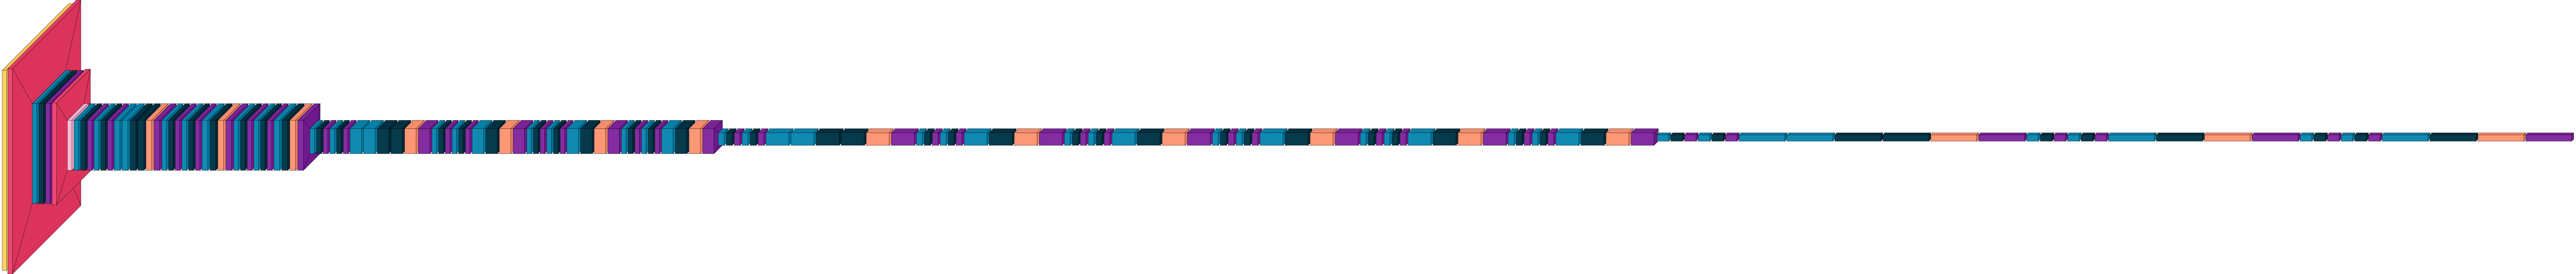

In [12]:
file_path = '/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models/'
image_path = os.path.join(file_path, 'resnet50.png')
visualkeras.layered_view(resnet_model, to_file=image_path)
display(Image(filename=image_path))

In [ ]:
# # comment if done
# save extracted features
# X, y, note_paths = extract_features(dataset_dir, resnet_model)

# # save
# np.save('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/resnet50/X.npy', X)
# np.save('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/resnet50/y.npy', y)
# np.save('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/resnet50/note_paths.npy', note_paths)

In [13]:
# load extracted features
X = np.load('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/resnet50/X.npy')
y = np.load('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/resnet50/y.npy')
note_paths = np.load('/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/data/resnet50/note_paths.npy')

In [14]:
# data split
X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(X, y, note_paths, test_size=0.4, random_state=seed)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=seed)


In [15]:
# model prep/training
input_tensor = Input(shape=(X.shape[1], 7, 7, 2048)) 

# Calculate the output shape of the Lambda layer
def lambda_output_shape(input_shape):
  return [(input_shape[0],) + input_shape[2:]] * input_shape[1]

# Wrap the lambda function in a regular function
def unstack_tensor(x):
  # return tf.unstack(x, axis=1)
  return tf.compat.v1.unstack(x, axis=1)

# split_tensors = Lambda(lambda x: tf.unstack(x, axis=1))(input_tensor)
split_tensors = Lambda(unstack_tensor, output_shape=lambda_output_shape)(input_tensor)

branches = [Flatten()(split_tensors[i]) for i in range(X.shape[1])]
concat = Concatenate()(branches)
dropout = Dropout(0.6)(concat)
fcnn = Dense(64, activation='relu', kernel_regularizer=l2(0.00005))(dropout)  # Added L2 regularization
fcnn = Dense(1, activation='sigmoid')(fcnn)
model = Model(inputs=input_tensor, outputs=fcnn)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [16]:
# directory to save best Model
best_model_dir = '/content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models'

In [17]:
# Define the ModelCheckpoint callback with the updated file path
best_model_file_path = os.path.join(best_model_dir, 'resnet50_model.keras')
checkpoint = ModelCheckpoint(best_model_file_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])



Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8105 - loss: 16.2751
Epoch 1: val_loss improved from inf to 2.10448, saving model to /content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models/resnet50_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - accuracy: 0.8139 - loss: 16.0406 - val_accuracy: 0.9928 - val_loss: 2.1045
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9800 - loss: 2.8154
Epoch 2: val_loss improved from 2.10448 to 0.97836, saving model to /content/drive/MyDrive/Colab_Notebooks/banknote_authentication/models/resnet50_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.9802 - loss: 2.7727 - val_accuracy: 0.9892 - val_loss: 0.9784
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9890 - loss: 0.5537
Epoch 3: val_loss did not improve from 0.97836
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.9891 - loss: 0.5496 - val_accuracy: 0.9892 - val_loss: 1.0266
Epoch 4/20
27/27 ━━━━━━━━

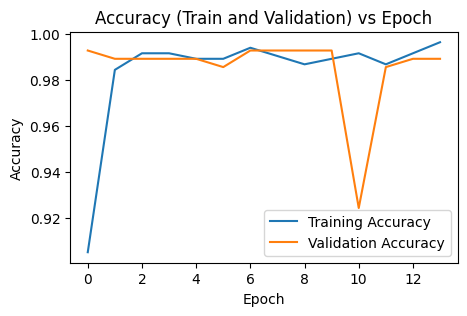

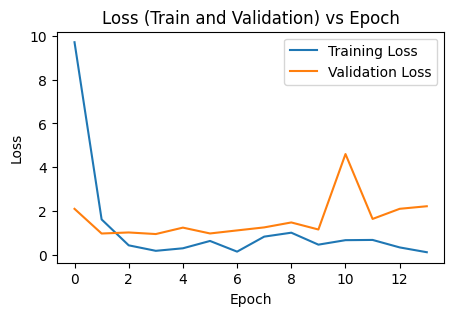

In [18]:
# Plot the training and validation accuracy vs epoch
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (Train and Validation) vs Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss vs epoch
fig, ax = plt.subplots(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Train and Validation) vs Epoch')
plt.legend(loc='upper right')
plt.show()

In [19]:
# load best model saved by ModelCheckpoint
# best_model = tf.keras.models.load_model(best_model_file_path)
best_model = load_model(best_model_file_path,
                       custom_objects={'unstack_tensor': unstack_tensor,
                                       'lambda_output_shape': lambda_output_shape},
                       safe_mode=False)

test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9858 - loss: 1.6192
Test loss: 0.9826859831809998
Test accuracy: 0.9856114983558655


In [20]:
# Evaluate the best model on the validation set
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_acc}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9928 - loss: 0.3283
Validation loss: 0.9541968703269958
Validation accuracy: 0.9892086386680603


In [21]:
# Get the predicted labels on test set
predictions = best_model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


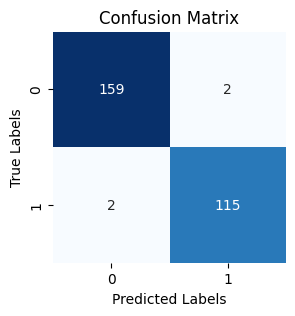

In [23]:
# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, ax=ax , fmt='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [24]:
# Calculate and print precision, recall, and F1 score
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Precision: 0.98
Recall: 0.98
F1 score: 0.98


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


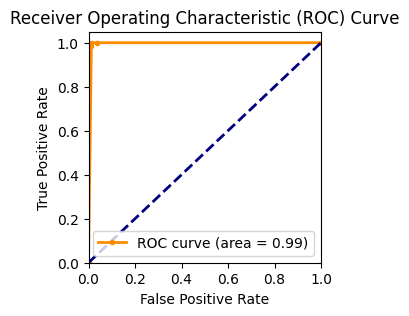

In [25]:
# Make predictions using the best model and get probabilities
y_pred_probs = best_model.predict(X_test)

# Calculate the FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, marker='o', markersize=3 , label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

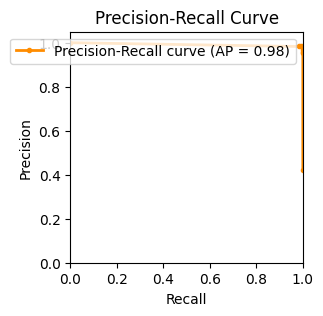

In [26]:
# Calculate precision, recall, and threshold values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Calculate the average precision
average_precision = average_precision_score(y_test, y_pred_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(3, 3))
plt.plot(recall, precision, color='darkorange', lw=2,marker='o', markersize=3, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()
